In [3]:
%%capture
%pip install accelerate -U
%pip install transformers[torch]

In [1]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

c:\source\repos\Models-Inferencing-On-Client-Sandbox\sandboxenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
checkpoint = "hustvl/yolos-tiny"
teacher_processor = AutoImageProcessor.from_pretrained(checkpoint)
teacher_model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    ignore_mismatched_sizes=True,
)

# pretrained model to start w/ - https://huggingface.co/hustvl/yolos-tiny
# dataset to finetune on - https://huggingface.co/datasets/wider_face

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [4]:
%%capture
%pip install datasets

In [3]:
from datasets import load_dataset, load_from_disk
import os


train_dir = "C:/source/repos/Models-Inferencing-On-Client-Sandbox/datasets/image-face-dataset/train"
test_dir = "C:/source/repos/Models-Inferencing-On-Client-Sandbox/datasets/image-face-dataset/test"
validation_dir = "C:/source/repos/Models-Inferencing-On-Client-Sandbox/datasets/image-face-dataset/validation"

is_data_local: bool = os.path.exists(train_dir) and os.path.exists(test_dir) and os.path.exists(validation_dir)
is_using_subset: bool = True

if is_data_local:
    train_dataset = load_from_disk(train_dir)
    test_dataset = load_from_disk(test_dir)
    validation_dataset = load_from_disk(validation_dir)
else:
    train_dataset = load_dataset("wider_face", split="train[:5%]")
    test_dataset = load_dataset("wider_face", split="test[:5%]")
    validation_dataset = load_dataset("wider_face", split="validation[:5%]")
    train_dataset.save_to_disk(train_dir)
    test_dataset.save_to_disk(test_dir)
    validation_dataset.save_to_disk(validation_dir)

In [4]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset,
    'validation': validation_dataset,
})

dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'faces'],
        num_rows: 644
    })
    test: Dataset({
        features: ['image', 'faces'],
        num_rows: 805
    })
    validation: Dataset({
        features: ['image', 'faces'],
        num_rows: 161
    })
})

In [12]:
%%capture
!pip install -U albumentations opencv-python

In [5]:
from typing import Any, Dict


example: Dict[Any, Any] = dataset["train"][2]

example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 'faces': {'bbox': [[78.0, 221.0, 7.0, 8.0],
   [78.0, 238.0, 14.0, 17.0],
   [113.0, 212.0, 11.0, 15.0],
   [134.0, 260.0, 15.0, 15.0],
   [163.0, 250.0, 14.0, 17.0],
   [201.0, 218.0, 10.0, 12.0],
   [182.0, 266.0, 15.0, 17.0],
   [245.0, 279.0, 18.0, 15.0],
   [304.0, 265.0, 16.0, 17.0],
   [328.0, 295.0, 16.0, 20.0],
   [389.0, 281.0, 17.0, 19.0],
   [406.0, 293.0, 21.0, 21.0],
   [436.0, 290.0, 22.0, 17.0],
   [522.0, 328.0, 21.0, 18.0],
   [643.0, 320.0, 23.0, 22.0],
   [653.0, 224.0, 17.0, 25.0],
   [793.0, 337.0, 23.0, 30.0],
   [535.0, 311.0, 16.0, 17.0],
   [29.0, 220.0, 11.0, 15.0],
   [3.0, 232.0, 11.0, 15.0],
   [20.0, 215.0, 12.0, 16.0]],
  'blur': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
  'expression': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'illumination': [0,
   0,
   0,
   0,
   0,
 

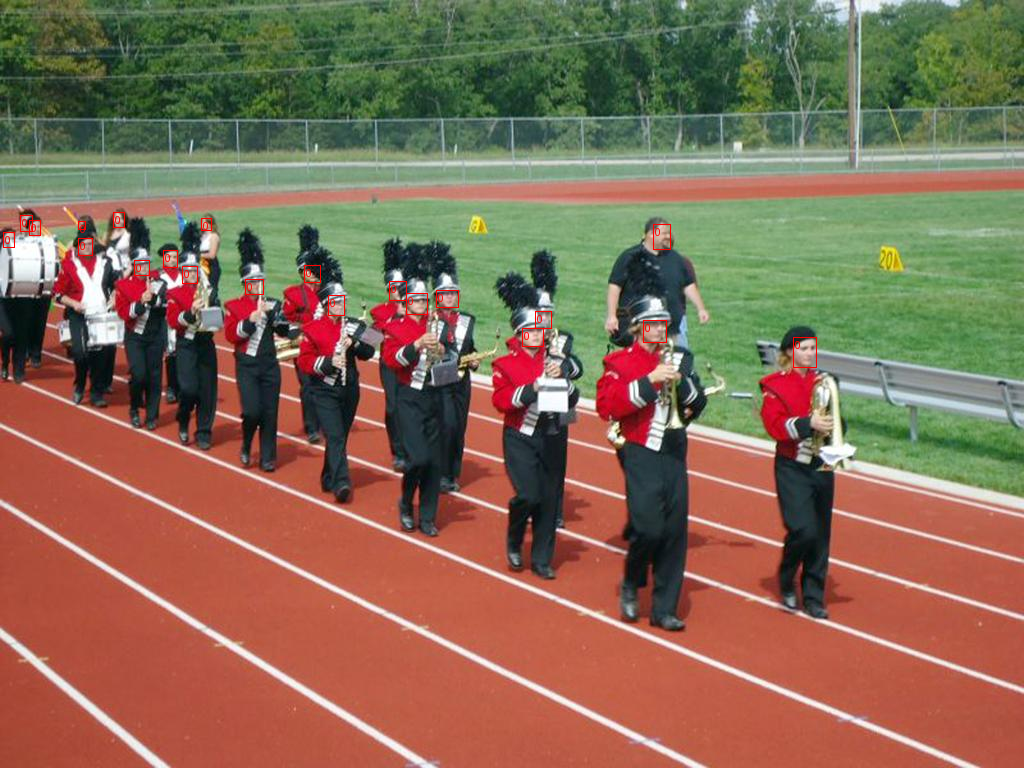

In [6]:
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

boxes_xywh = torch.tensor(example['faces']['bbox'])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [str(x) for x in example['faces']['expression']]
to_pil_image(
    draw_bounding_boxes(
        pil_to_tensor(example['image']),
        boxes_xyxy,
        colors="red",
        labels=labels
    )
)

In [7]:
import albumentations
import numpy as np

transform = albumentations.Compose([
    albumentations.Resize(480, 480),
    albumentations.HorizontalFlip(p=1.0),
    albumentations.RandomBrightnessContrast(p=1.0),
], bbox_params=albumentations.BboxParams(format='coco', label_fields=['expression']))

image = np.array(example['image'])
out = transform(
    image=image,
    bboxes=example['faces']['bbox'],
    expression=example['faces']['expression']
)

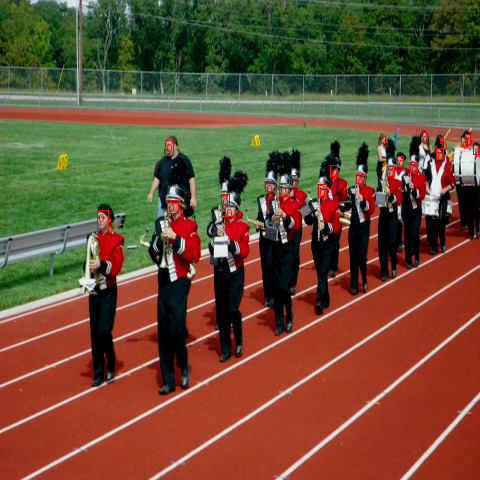

In [8]:
image = torch.tensor(out['image']).permute(2, 0, 1)
boxes_xywh = torch.stack([torch.tensor(x) for x in out['bboxes']])
boxes_xyxy = box_convert(boxes_xywh, 'xywh', 'xyxy')
labels = [str(x) for x in out['expression']]
to_pil_image(
    draw_bounding_boxes(
        image,
        boxes_xyxy,
        colors='red',
        labels=labels
    )
)

In [9]:
def formatted_annotations(image_id, expression, bbox):
    annotations = []
    for i in range(0, len(expression)):
        new_ann = {
            "image_id": image_id,
            "category_id": expression[i],
            "isCrowd": 0,
            "area": 10,
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)
    
    return annotations

In [29]:
# LEFT OFF HERE
# augment image and transform annotations in batches
def transform_augment_annotate_batch(examples):
    image_ids = list(range(0, len(examples["image"])))
    images, bboxes, expressions = [], [], []
    
    for image, faces in zip(examples["image"], examples["faces"]):
        image = np.array(image.convert("RGB"))[:,:,::-1]
        out = transform(image=image, bboxes=faces["bbox"], expression=faces["expression"])
    
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        expressions.append(out["expression"])
    
    targets = [
                {"image_id": id_, "annotations": formatted_annotations(id_, expr_, box_)}
        for id_, expr_, box_ in zip(image_ids, expressions, bboxes)
    ]
    print('targets: ',targets)
    return teacher_processor(images=images, annotations=targets, return_tensors="pt")
        
        
        

In [30]:
dataset["train"] = dataset["train"].with_transform(transform_augment_annotate_batch)

In [19]:
# OLD -- DONT RUN THIS -> USE TRANSFORM_AUGMENT_ANNOTATE_BATCH() INSTEAD
def transforms(examples):
    images, bboxes, expressions = [], [], []
    for image, objects in zip(examples['image'], examples['faces']):
        image = np.array(image.convert("RGB"))
        out = transform(
            image=image,
            bboxes=objects['bbox'],
            expression=objects['expression']
        )
        images.append(torch.tensor(out['image']).permute(2, 0, 1))
        bboxes.append(torch.tensor(out['bboxes']))
        expressions.append(out['expression'])
    return {'image': images, 'bbox': bboxes, 'expression': expressions}

In [20]:
# OLD -- DONT RUN THIS
dataset['train'].set_transform(transforms)

In [31]:
temp = dataset["train"][15]

temp

targets:  [{'image_id': 0, 'annotations': [{'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [437.34375, 197.3568281938326, 8.4375, 17.621145374449327]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [385.3125, 195.94713656387665, 8.4375, 12.687224669603523]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [373.125, 186.78414096916302, 6.09375, 11.277533039647551]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [364.6875, 195.94713656387665, 9.375, 16.211453744493383]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [319.6875, 185.37444933920705, 7.96875, 13.392070484581495]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [304.21875, 174.80176211453744, 10.3125, 16.211453744493383]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [309.375, 195.94713656387665, 7.96875, 17.621145374449355]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'are

{'pixel_values': tensor([[[-1.3644, -1.2617, -1.1932,  ..., -1.2959, -1.3130, -1.2617],
          [-1.5185, -1.4329, -1.3644,  ..., -1.2959, -1.3473, -1.1760],
          [-1.5357, -1.5357, -1.5185,  ..., -1.2274, -1.2445, -1.1589],
          ...,
          [ 0.7591,  0.6049,  0.6392,  ...,  0.7933,  0.7933,  0.6563],
          [ 0.5364,  0.4166,  0.4166,  ...,  0.8789,  1.1358,  1.0502],
          [ 0.4508,  0.4337,  0.4851,  ...,  0.7762,  1.0673,  1.0673]],
 
         [[-1.0728, -1.0028, -0.9153,  ..., -1.0028, -1.0203, -0.9503],
          [-1.2479, -1.1604, -1.0728,  ..., -1.0028, -1.0378, -0.8803],
          [-1.2654, -1.2479, -1.2479,  ..., -0.9153, -0.9503, -0.8452],
          ...,
          [ 0.9930,  0.8179,  0.8704,  ...,  1.1155,  1.1506,  1.0105],
          [ 0.7654,  0.6429,  0.6429,  ...,  1.1856,  1.5007,  1.4132],
          [ 0.6779,  0.6604,  0.7129,  ...,  1.0805,  1.4132,  1.4307]],
 
         [[-1.0550, -0.9504, -0.8981,  ..., -0.8981, -0.9156, -0.8458],
          [-

In [13]:
# now whole dataset should be preprocessed
example = dataset['train'][400]
to_pil_image(
    draw_bounding_boxes(
        example['image'],
        box_convert(example['bbox'], 'xywh', 'xyxy'),
        colors='red',
        labels=[str(x) for x in example['expression']]
    )
)

KeyError: 'image'

In [35]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = teacher_processor.pad(pixel_values, return_tensors="pt")
    # labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    # batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="finetuned-tiny-yolo-face",
    per_device_train_batch_size=8,
    num_train_epochs=10,
    save_steps=200,
    logging_steps=50,
    learning_rate=1e-5,
    weight_decay=1e-4,
    save_total_limit=2,
    remove_unused_columns=False,
)

In [36]:
from transformers import Trainer

trainer = Trainer(
    model=teacher_model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=dataset["train"], # type: ignore
    tokenizer=teacher_processor,
)

trainer.train()

targets:  [{'image_id': 0, 'annotations': [{'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [6.5625, 368.75, 4.21875, 8.125]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [82.5, 381.25, 4.6875, 9.375]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [169.6875, 390.0, 5.625, 8.75]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [63.28125, 334.375, 4.21875, 10.0]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [107.34375, 343.125, 3.75, 6.25]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [133.59375, 310.625, 5.15625, 8.125]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [153.75, 321.25, 4.21875, 8.75]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [213.28125, 317.5, 5.15625, 8.75]}, {'image_id': 0, 'category_id': 0, 'isCrowd': 0, 'area': 10, 'bbox': [196.875, 299.375, 4.6875, 10.0]}, {'image_id': 0, 'category_id'

KeyError: 'labels'